# Modelo 2 Randon Florest

## 1. Importação de Bibliotecas

Propósito: Importa todas as bibliotecas necessárias para:

* Manipulação de dados (pandas, numpy)

* Visualização (matplotlib, seaborn, wordcloud)

* Machine Learning (scikit-learn)

* Processamento de texto (regex)

In [53]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, accuracy_score
)
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

## 2. Configuração de Estilo Visual

Função: Define o estilo visual padrão para todos os gráficos usando temas profissionais do ggplot e paleta de cores suaves.

In [54]:
# Estilo dos gráficos
plt.style.use('ggplot')
sns.set_palette('pastel')

## 3. Carregamento de Dados

Principais operações:

* Combina múltiplos arquivos CSV

* Padroniza nomes de colunas usando regex

* Identifica automaticamente a coluna de satisfação (P2_k)

*  Cria variável binária Satisfacao_atual

In [55]:

# Função para carregar e preparar os dados
def carregar_dados(paths: list) -> pd.DataFrame:
    dados_combinados = pd.DataFrame()
    for path in paths:
        dados = pd.read_csv(path)

        # Extrai o código da variável do nome da coluna no formato ("'P1_a'", ...)
        def extrair_codigo(col_str):
            m = re.match(r"\(\s*'([^']+)'\s*,.*", col_str)
            return m.group(1).strip() if m else col_str.strip()

        dados.columns = [extrair_codigo(c) for c in dados.columns]
        dados_combinados = pd.concat([dados_combinados, dados], ignore_index=True)

    # Detecta automaticamente a coluna de satisfação (ex: "P2_k_1")
    satis_cols = [c for c in dados_combinados.columns if c.startswith("P2_k")]
    if not satis_cols:
        raise KeyError("Coluna de satisfação (P2_k...) não encontrada")

    col_satisf = satis_cols[0]
    print(f"Coluna de satisfação detectada: '{col_satisf}'")

    # Converte valores de satisfação para 0 e 1
    dados_combinados["Satisfacao_atual"] = (
        dados_combinados[col_satisf]
        .map({1.0: 1, 0.0: 0})
        .fillna(0)
        .astype(int)
    )

    return dados_combinados



## 4. Análise Exploratória

Visualizações criadas:

* Distribuição da variável target (satisfação)

* Distribuição salarial dos respondentes

* Anotações precisas com contagens absolutas

In [56]:

# Função de análise exploratória simples
def analise_exploratoria(dados: pd.DataFrame):
    plt.figure(figsize=(8,5))
    ax = sns.countplot(x='Satisfacao_atual', data=dados)
    plt.title('Distribuição da Satisfação')
    plt.xlabel('Satisfação (0=Insatisfeito, 1=Satisfeito)')
    plt.ylabel('Contagem')

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}',
                    (p.get_x() + p.get_width()/2., p.get_height()),
                    ha='center', va='center', xytext=(0,5), textcoords='offset points')
    plt.show()

    if 'P2_h' in dados.columns:
        plt.figure(figsize=(12,6))
        ordem = dados['P2_h'].value_counts().index
        sns.countplot(y='P2_h', data=dados, order=ordem)
        plt.title('Distribuição por Faixa Salarial (P2_h)')
        plt.xlabel('Contagem')
        plt.ylabel('Faixa Salarial')
        plt.tight_layout()
        plt.show()


## 5. Pré-processamento

Etapas-chave:

* Seleção de features específicas

* Tratamento de valores faltantes

* Codificação categórica com LabelEncoder

* Separação em features (X) e target (y)

In [57]:
# Função de pré-processamento dos dados
def preprocessamento(dados: pd.DataFrame):
    variaveis = {
        "P1_a_1": "Idade",
        "P1_b": "Idade",
        "P1_c": "Cor/Raça/Etnia",
        "P1_d": "PCD",
        "P1_l": "Nivel de Ensino",
        "P2_a": "Qual sua Situação de Trabalho",
        "P2_b": "Setor",
        "P2_c": "Numero de Funcionarios",
        "P2_d": "Gestor",
        "P2_f": "Cargo Atual",
        "P2_g": "Nivel",
        "P2_h": "Faixa Salarial",
        "P2_i": "Tempo na area de dados",
        "P2_j": "Tempo na area de TI e software",
        "P2_r": "Forma de Trabalho Atual",
        "P2_s": "Forma de Trababalho ideal",
        "P3_a": "Pessoas que Trabalham com Dados",
        "P4_d_1": "Novos Talentos",
        "P4_d_3": "Empresa Atual Investir em Dados",
        "P4_h_1": "Azure",
        "P4_h_2": "AWS",
        "P4_h_3": "GCP",
        "P4_j_1": "Bl",
        "P4_j_3": "Tableu",
        "P4_m_1": "IA Generativa",
        "P4_m_2": "IA Generativa Gratis",
        "P4_m_3": "IA Generativa Paga",
        "P4_m_5": "Copílote",
    } # Ensure the dictionary definition is closed here

    disponiveis = [v for v in variaveis if v in dados.columns]

    if not disponiveis:
        raise ValueError("Nenhuma das variáveis de features está presente no DataFrame.")

    print(f'Usando {len(disponiveis)} features para modelagem.')

    X = dados[disponiveis].fillna('Não informado')
    y = dados['Satisfacao_atual']

    # Codifica todas as colunas como inteiros (necessário para Random Forest)
    for col in X.columns:
        X[col] = X[col].astype(str)
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

    return X, y

## 6. Modelagem com Random Forest
Fluxo de trabalho:

* Divisão estratificada treino/teste (80/20)

* Pipeline com SMOTE para balanceamento

* Random Forest com ajuste de pesos


Métricas detalhadas:

* Acurácia

* Matriz de confusão

* Curva ROC/AUC

* Relatório de classificação

In [58]:

from sklearn.model_selection import GridSearchCV

def treinar_e_validar_rf(X, y):
    # Divide dados em treino e teste (80/20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Defina o pipeline
    pipeline = make_pipeline(
        SMOTE(random_state=42),
        RandomForestClassifier(random_state=42, class_weight='balanced')
    )

    # Define os parâmetros a serem testados
    param_grid = {
        'randomforestclassifier__n_estimators': [10, 50], # Diminui o número de árvores
        'randomforestclassifier__max_depth': [None, 10, 20], # Exemplo de outros parâmetros para otimizar
        'randomforestclassifier__min_samples_split': [2, 5, 10],
        'randomforestclassifier__min_samples_leaf': [1, 2, 4],
        'randomforestclassifier__ccp_alpha': [0.0, 0.001, 0.01, 0.1] # Parâmetro para poda
    }

    # Configura o GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=StratifiedKFold(5), scoring='accuracy', n_jobs=-1)

    # Treina com os dados de treino para encontrar os melhores parâmetros
    grid_search.fit(X_train, y_train)

    print("Melhores parâmetros encontrados:")
    print(grid_search.best_params_)

    # Usa o melhor modelo encontrado
    modelo = grid_search.best_estimator_

    # Predições com o melhor modelo
    y_train_pred = modelo.predict(X_train)
    y_test_pred = modelo.predict(X_test)

    # Probabilidades para ROC (usando predict_proba para a classe positiva)
    y_train_proba = modelo.predict_proba(X_train)[:, 1]
    y_test_proba = modelo.predict_proba(X_test)[:, 1]

    # Acurácia
    acc_train = accuracy_score(y_train, y_train_pred)
    acc_test = accuracy_score(y_test, y_test_pred)
    print(f"Acurácia no treino (melhor modelo): {acc_train:.3f}")
    print(f"Acurácia no teste (melhor modelo): {acc_test:.3f}")

    # Matriz de confusão
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)

    print("\nMatriz de Confusão - Treino (melhor modelo):")
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Insatisfeito', 'Satisfeito'])
    disp_train.plot(cmap='Blues')
    plt.show()

    print("Matriz de Confusão - Teste (melhor modelo):")
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Insatisfeito', 'Satisfeito'])
    disp_test.plot(cmap='Blues')
    plt.show()

    # Curva ROC
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

    auc_train = auc(fpr_train, tpr_train)
    auc_test = auc(fpr_test, tpr_test)

    plt.figure(figsize=(8,6))
    plt.plot(fpr_train, tpr_train, label=f'Treino (AUC = {auc_train:.3f})')
    plt.plot(fpr_test, tpr_test, label=f'Teste (AUC = {auc_test:.3f})')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title('Curva ROC - Treino e Teste (melhor modelo)')
    plt.legend()
    plt.show()

    # Relatório de Classificação
    print("\nRelatório de Classificação (Treino, melhor modelo):")
    print(classification_report(y_train, y_train_pred))

    print("\nRelatório de Classificação (Teste, melhor modelo):")
    print(classification_report(y_test, y_test_pred))

    return modelo, grid_search.best_estimator_ # Retorna o melhor estimador para a curva de aprendizado

## 7. Diagnóstico de Modelo


In [59]:

# Função para plotar curva de aprendizagem
def plotar_curva_aprendizagem(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        random_state=42
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Acurácia Treino')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Acurácia Validação')
    plt.xlabel('Número de amostras de treino')
    plt.ylabel('Acurácia')
    plt.title('Curva de Aprendizagem')
    plt.legend()
    plt.grid(True)
    plt.show()

## 8. Análise de Texto


In [60]:

# Função para gerar a nuvem de palavras
def gerar_nuvem_palavras(dados: pd.DataFrame, col_comentarios: str):
    # Filtra os comentários dos profissionais satisfeitos e insatisfeitos
    comentarios_satisfeitos = dados[dados['Satisfacao_atual'] == 1][col_comentarios].dropna().astype(str)
    comentarios_insatisfeitos = dados[dados['Satisfacao_atual'] == 0][col_comentarios].dropna().astype(str)

    # Junta todos os comentários em uma única string
    texto_satisfeitos = ' '.join(comentarios_satisfeitos)
    texto_insatisfeitos = ' '.join(comentarios_insatisfeitos)

    # Gera as nuvens de palavras
    wordcloud_satisfeitos = WordCloud(width=800, height=400, background_color='white').generate(texto_satisfeitos)
    wordcloud_insatisfeitos = WordCloud(width=800, height=400, background_color='white').generate(texto_insatisfeitos)

    # Exibe as nuvens de palavras
    plt.figure(figsize=(10, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_satisfeitos, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nuvem de Palavras - Satisfeitos')

    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_insatisfeitos, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nuvem de Palavras - Insatisfeitos')


## 9. Fluxo Principal

Coluna de satisfação detectada: 'P2_k'


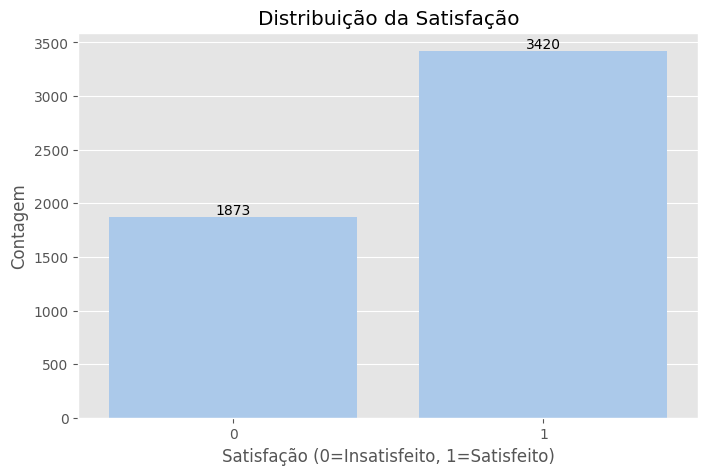

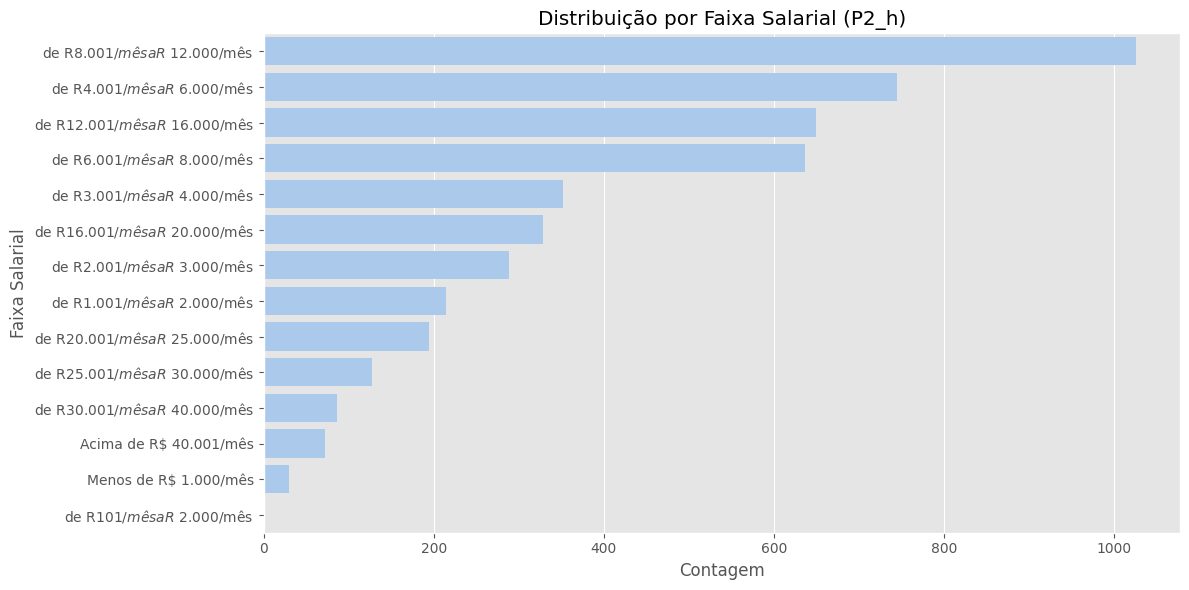

Usando 28 features para modelagem.
Melhores parâmetros encontrados:
{'randomforestclassifier__ccp_alpha': 0.01, 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 50}
Acurácia no treino (melhor modelo): 0.761
Acurácia no teste (melhor modelo): 0.754

Matriz de Confusão - Treino (melhor modelo):


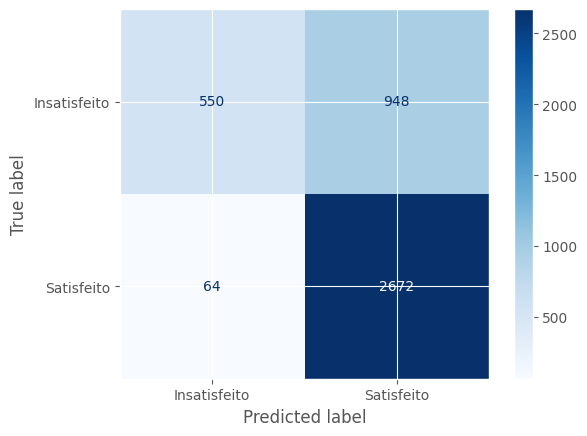

Matriz de Confusão - Teste (melhor modelo):


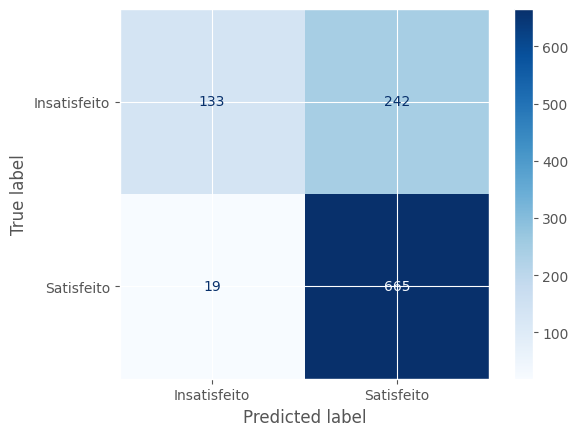

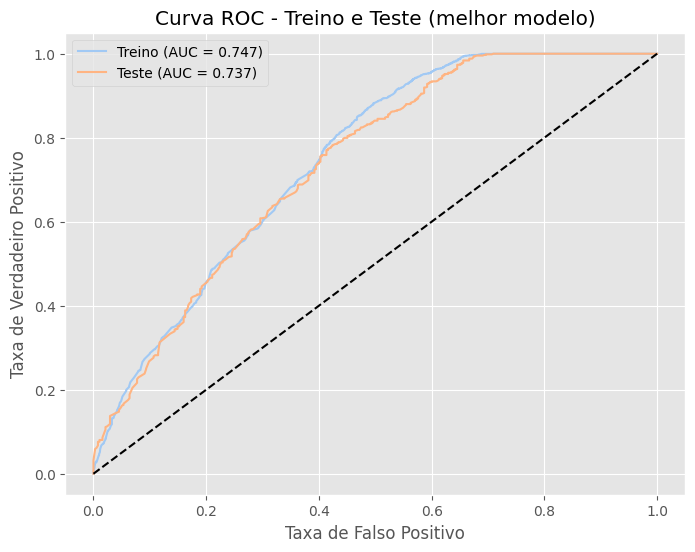


Relatório de Classificação (Treino, melhor modelo):
              precision    recall  f1-score   support

           0       0.90      0.37      0.52      1498
           1       0.74      0.98      0.84      2736

    accuracy                           0.76      4234
   macro avg       0.82      0.67      0.68      4234
weighted avg       0.79      0.76      0.73      4234


Relatório de Classificação (Teste, melhor modelo):
              precision    recall  f1-score   support

           0       0.88      0.35      0.50       375
           1       0.73      0.97      0.84       684

    accuracy                           0.75      1059
   macro avg       0.80      0.66      0.67      1059
weighted avg       0.78      0.75      0.72      1059



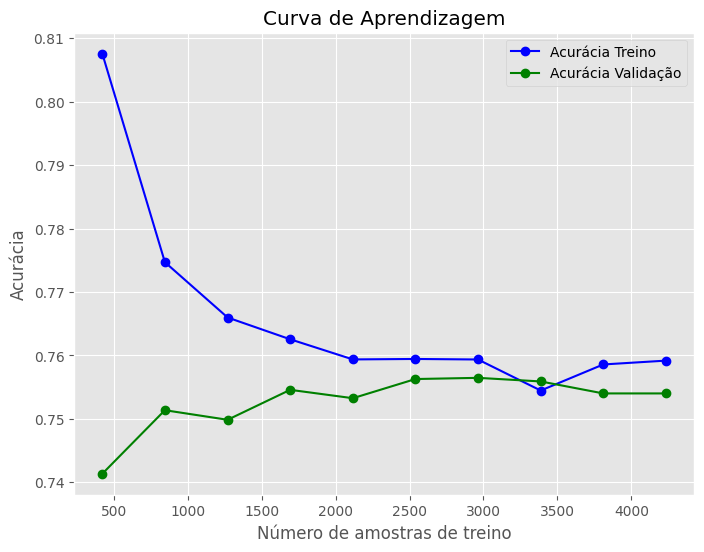

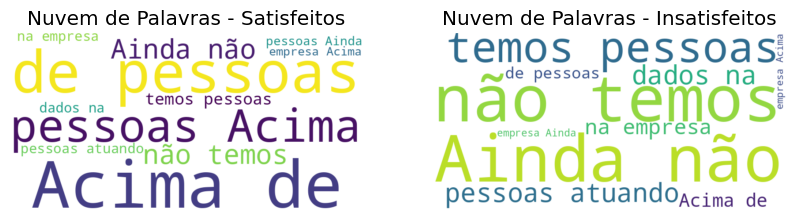

In [61]:


# Função principal: executa o pipeline completo
def main():
    arquivos = [
        "State_of_data_BR_2023_Kaggle - df_survey_2023.csv"
    ]

    try:
        dados = carregar_dados(arquivos)
        analise_exploratoria(dados)
        X, y = preprocessamento(dados)
        modelo, melhor_estimador = treinar_e_validar_rf(X, y)

        # Curva de aprendizagem com RandomForest
        from sklearn.ensemble import RandomForestClassifier
        plotar_curva_aprendizagem(
        melhor_estimador, # Usar o melhor estimador do GridSearchCV
        X, y
    )

        # Gerar nuvem de palavras para profissionais satisfeitos e insatisfeitos

        gerar_nuvem_palavras(dados, 'P3_a')  # 'P3_a' é um exemplo de coluna com comentários
    except Exception as e:
          print(f"Erro ao processar dados: {e}")

if __name__ == "__main__":
    main()